In [1]:
from datasets import Dataset, load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForSeq2Seq
from peft import (
    LoraConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
import random
import numpy as np
import torch

从 Huggingface Hub 中提取数据集，并将其中的 10% 分成评估集，以检查模型在训练中的表现如何。如果您想加载自己的数据集，请执行以下操作：
train_dataset = load_dataset('json', data_files='train_set.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='validation_set.jsonl', split='train')

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
dataset = load_dataset("b-mc2/sql-create-context", split="train")
train_dataset = dataset.train_test_split(test_size=0.1)["train"]
eval_dataset = dataset.train_test_split(test_size=0.1)["test"]

Using the latest cached version of the dataset since b-mc2/sql-create-context couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/b-mc2___sql-create-context/default/0.0.0/9d80a6a118b838d9defc3798d659a54a2ac2ff37 (last modified on Sun Jan  5 13:45:14 2025).


In [4]:
dataset

Dataset({
    features: ['question', 'context', 'answer'],
    num_rows: 78577
})

In [5]:
print(train_dataset[3])

{'question': 'What championship had Francesca Schiavone in the finals?', 'context': 'CREATE TABLE table_name_81 (championship VARCHAR, opponent_in_the_final VARCHAR)', 'answer': 'SELECT championship FROM table_name_81 WHERE opponent_in_the_final = "francesca schiavone"'}


In [6]:
base_model = "/workspace/LLM-finetune/codeLLM/huggingface/unsloth/facebook-opt-350m"

# max_memory={0: "1GiB", 1: "38GiB"}

model = AutoModelForCausalLM.from_pretrained(
    base_model,
    # load_in_8bit=True,
    # torch_dtype=torch.float16,
    device_map = "auto", 
    # max_memory=max_memory,
)
tokenizer = AutoTokenizer.from_pretrained(
    base_model,
    device_map = "auto", 
    # max_memory=max_memory,
)

## 初始性能评测

In [8]:
eval_prompt = """You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given a question and context regarding one or more tables.

You must output the SQL query that answers the question.
### Input:
Which Class has a Frequency MHz larger than 91.5, and a City of license of hyannis, nebraska?

### Context:
CREATE TABLE table_name_12 (class VARCHAR, frequency_mhz VARCHAR, city_of_license VARCHAR)

### Response:
"""
# {'question': 'Name the comptroller for office of prohibition', 'context': 'CREATE TABLE table_22607062_1 (comptroller VARCHAR, ticket___office VARCHAR)', 'answer': 'SELECT comptroller FROM table_22607062_1 WHERE ticket___office = "Prohibition"'}
model_input = tokenizer(eval_prompt, return_tensors="pt").to(0)

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=50)[0], skip_special_tokens=True))

You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given a question and context regarding one or more tables.

You must output the SQL query that answers the question.
### Input:
Which Class has a Frequency MHz larger than 91.5, and a City of license of hyannis, nebraska?

### Context:
CREATE TABLE table_name_12 (class VARCHAR, frequency_mhz VARCHAR, city_of_license VARCHAR)

### Response:
SELECT * FROM table_name_12 WHERE frequency_mhz = 91.5, city_of_license = hyannis,

### Output:
SELECT * FROM table_name_12 WHERE frequency_mhz = 91.5


## 正确答案
SELECT class FROM table_name_12 WHERE frequency_mhz > 91.5 AND city_of_license = "hyannis, nebraska"

## 格式化样本

In [9]:
def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=512,
        padding=False,
        return_tensors=None,
    )

    # "self-supervised learning" means the labels are also the inputs:
    result["labels"] = result["input_ids"].copy()

    return result
    
def generate_and_tokenize_prompt(data_point):
    full_prompt =f"""You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given a question and context regarding one or more tables.

You must output the SQL query that answers the question.

### Input:
{data_point["question"]}

### Context:
{data_point["context"]}

### Response:
{data_point["answer"]}
"""
    return tokenize(full_prompt)

tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/70719 [00:00<?, ? examples/s]

Map:   0%|          | 0/7858 [00:00<?, ? examples/s]

In [10]:
print(tokenized_train_dataset[1])

{'question': 'Which Games have a Drawn smaller than 1, and a Lost smaller than 1?', 'context': 'CREATE TABLE table_name_91 (games VARCHAR, drawn VARCHAR, lost VARCHAR)', 'answer': 'SELECT games FROM table_name_91 WHERE drawn < 1 AND lost < 1', 'input_ids': [2, 1185, 32, 10, 2247, 2788, 12, 560, 12, 46608, 1421, 4, 2486, 633, 16, 7, 1948, 1142, 59, 10, 8503, 4, 370, 32, 576, 10, 864, 8, 5377, 2624, 65, 50, 55, 9248, 4, 50118, 50118, 1185, 531, 4195, 5, 41614, 25860, 14, 5274, 5, 864, 4, 50118, 50118, 48134, 41327, 35, 50118, 32251, 3100, 33, 10, 44242, 2735, 87, 112, 6, 8, 10, 13932, 2735, 87, 112, 116, 50118, 50118, 48134, 43885, 35, 50118, 45503, 8625, 41910, 2103, 1215, 13650, 1215, 6468, 36, 34732, 468, 42499, 2747, 6, 4777, 468, 42499, 2747, 6, 685, 468, 42499, 2747, 43, 50118, 50118, 48134, 19121, 35, 50118, 49179, 426, 11974, 2103, 1215, 13650, 1215, 6468, 29919, 4777, 28696, 112, 4248, 685, 28696, 112, 50118], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [11]:
model.train() # put model back into training mode
# model = prepare_model_for_int8_training(model)

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=[
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)

In [12]:
model.print_trainable_parameters()
# 获取当前模型占用的 GPU显存（差值为预留给 PyTorch 的显存）
memory_footprint_bytes = model.get_memory_footprint()
memory_footprint_mib = memory_footprint_bytes / (1024 ** 3)  # 转换为 GB

print(f"{memory_footprint_mib:.2f}GB")

trainable params: 2,359,296 || all params: 333,555,712 || trainable%: 0.7073
1.24GB


In [13]:
model_dir = "/workspace/LLM-finetune/codeLLM/outputs"
model_id  = "opt-350m"
training_args = SFTConfig(
        output_dir=f"{model_dir}/{model_id}-lora-sql",  # 指定模型输出和保存的目录
        per_device_train_batch_size=8,  # 每个设备上的训练批量大小
        learning_rate=1e-4,  # 学习率
        max_seq_length=1024,
        # fp16=True,  # 启用混合精度训练，可以提高训练速度，同时减少内存使用
        optim="adamw_torch",
        logging_steps=50,  # 指定日志记录的步长，用于跟踪训练进度
        num_train_epochs=1,  # 训练的总轮数
        save_strategy="steps",
        warmup_ratio=0.1,
        lr_scheduler_type="constant",
        report_to="wandb",
        save_safetensors=True,
        seed=3407,
)

trainer = SFTTrainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=training_args,
    data_collator=DataCollatorForSeq2Seq(
        tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
    ),
)

nvidia-smi: line 14: /usr/bin/data-set: No such file or directory


In [14]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 446146024 (446146024-sun-yat-sen-university). Use `wandb login --relogin` to force relogin


Step,Training Loss
50,2.344800
100,1.165500
150,0.964000
200,0.918200
250,0.860400
300,0.837700
350,0.777300
400,0.782900
450,0.795000
500,0.755900


TrainOutput(global_step=8840, training_loss=0.6517374092637144, metrics={'train_runtime': 1418.1616, 'train_samples_per_second': 49.867, 'train_steps_per_second': 6.233, 'total_flos': 2.139832414175232e+16, 'train_loss': 0.6517374092637144, 'epoch': 1.0})

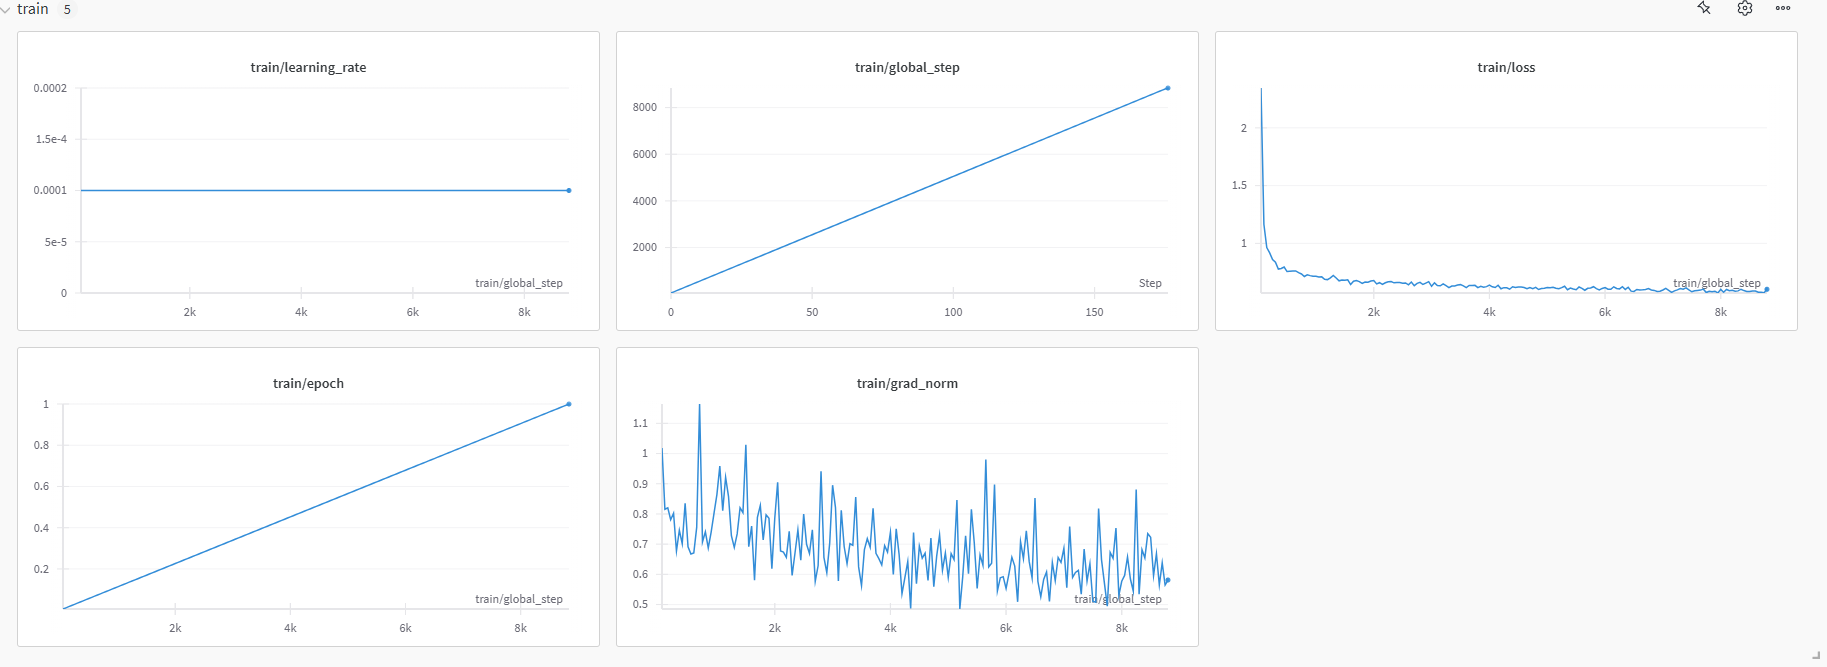

## 保存&推理

In [15]:
new_model = "/workspace/LLM-finetune/codeLLM/huggingface/unsloth/facebook-opt-350m-SQL"
trainer.save_model(new_model)

In [16]:
lora_model = trainer.model

In [19]:
eval_prompt = """You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given a question and context regarding one or more tables.

You must output the SQL query that answers the question.
### Input:
Which Class has a Frequency MHz larger than 91.5, and a City of license of hyannis, nebraska?

### Context:
CREATE TABLE table_name_12 (class VARCHAR, frequency_mhz VARCHAR, city_of_license VARCHAR)

### Response:
"""

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

lora_model.eval()
with torch.no_grad():
    print(tokenizer.decode(lora_model.generate(**model_input, max_new_tokens=50)[0], skip_special_tokens=True))

You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given a question and context regarding one or more tables.

You must output the SQL query that answers the question.
### Input:
Which Class has a Frequency MHz larger than 91.5, and a City of license of hyannis, nebraska?

### Context:
CREATE TABLE table_name_12 (class VARCHAR, frequency_mhz VARCHAR, city_of_license VARCHAR)

### Response:
SELECT class FROM table_name_12 WHERE frequency_mhz > 91.5 AND city_of_license = "hyannis, nebraska"

### Response:
SELECT frequency_mhz FROM table_name_12 WHERE frequency


## 正确答案
SELECT class FROM table_name_12 WHERE frequency_mhz > 91.5 AND city_of_license = "hyannis, nebraska"